In [ ]:
# default_exp retrieval

# Retrieval

> Module, containing the image retrieval by the global GeM descriptor similarity. Contains the code borrowed from
> https://github.com/filipradenovic/cnnimageretrieval-pytorch

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from local_feature_tutorial.datasets import *

In [ ]:
#export
import os.path
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm 


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [ ]:
#export
# Took from https://github.com/filipradenovic/cnnimageretrieval-pytorch/blob/master/cirtorch/networks/imageretrievalnet.py
image_retrieval_license='''
MIT License

Copyright (c) 2016-2019 VRG, CTU Prague

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.'''

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

def l2n(x, eps=1e-6):
    return x / (torch.norm(x, p=2, dim=1, keepdim=True) + eps).expand_as(x)

def powerlaw(x, eps=1e-6):
    x = x + self.eps
    return x.abs().sqrt().mul(x.sign())

class L2N(nn.Module):

    def __init__(self, eps=1e-6):
        super(L2N,self).__init__()
        self.eps = eps

    def forward(self, x):
        return l2n(x, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'eps=' + str(self.eps) + ')'


class PowerLaw(nn.Module):

    def __init__(self, eps=1e-6):
        super(PowerLaw, self).__init__()
        self.eps = eps

    def forward(self, x):
        return LF.powerlaw(x, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'eps=' + str(self.eps) + ')'

class GeM(nn.Module):

    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', '\
                + 'eps=' + str(self.eps) + ')'

OUTPUT_DIM = {
    'alexnet'               :  256,
    'vgg11'                 :  512,
    'vgg13'                 :  512,
    'vgg16'                 :  512,
    'vgg19'                 :  512,
    'resnet18'              :  512,
    'resnet34'              :  512,
    'resnet50'              : 2048,
    'resnet101'             : 2048,
    'resnet152'             : 2048,
    'densenet121'           : 1024,
    'densenet169'           : 1664,
    'densenet201'           : 1920,
    'densenet161'           : 2208, # largest densenet
    'squeezenet1_0'         :  512,
    'squeezenet1_1'         :  512,
}

class ImageRetrievalNet(nn.Module):
    
    def __init__(self, features, lwhiten, pool, whiten, meta):
        super(ImageRetrievalNet, self).__init__()
        self.features = nn.Sequential(*features)
        self.lwhiten = lwhiten
        self.pool = pool
        self.whiten = whiten
        self.norm = L2N()
        self.meta = meta
    
    def forward(self, x):
        # x -> features
        o = self.features(x)

        # TODO: properly test (with pre-l2norm and/or post-l2norm)
        # if lwhiten exist: features -> local whiten
        if self.lwhiten is not None:
            # o = self.norm(o)
            s = o.size()
            o = o.permute(0,2,3,1).contiguous().view(-1, s[1])
            o = self.lwhiten(o)
            o = o.view(s[0],s[2],s[3],self.lwhiten.out_features).permute(0,3,1,2)
            # o = self.norm(o)

        # features -> pool -> norm
        o = self.norm(self.pool(o)).squeeze(-1).squeeze(-1)

        # if whiten exist: pooled features -> whiten -> norm
        if self.whiten is not None:
            o = self.norm(self.whiten(o))

        # permute so that it is Dx1 column vector per image (DxN if many images)
        return o#.permute(1,0)

    def __repr__(self):
        tmpstr = super(ImageRetrievalNet, self).__repr__()[:-1]
        tmpstr += self.meta_repr()
        tmpstr = tmpstr + ')'
        return tmpstr

    def meta_repr(self):
        tmpstr = '  (' + 'meta' + '): dict( \n' # + self.meta.__repr__() + '\n'
        tmpstr += '     architecture: {}\n'.format(self.meta['architecture'])
        tmpstr += '     local_whitening: {}\n'.format(self.meta['local_whitening'])
        tmpstr += '     pooling: {}\n'.format(self.meta['pooling'])
        tmpstr += '     regional: {}\n'.format(self.meta['regional'])
        tmpstr += '     whitening: {}\n'.format(self.meta['whitening'])
        tmpstr += '     outputdim: {}\n'.format(self.meta['outputdim'])
        tmpstr += '     mean: {}\n'.format(self.meta['mean'])
        tmpstr += '     std: {}\n'.format(self.meta['std'])
        tmpstr = tmpstr + '  )\n'
        return tmpstr


def init_network(params):

    # parse params with default values
    architecture = params.get('architecture', 'resnet50')
    local_whitening = params.get('local_whitening', False)
    pooling = params.get('pooling', 'gem')
    regional = params.get('regional', False)
    whitening = params.get('whitening', False)
    mean = params.get('mean', [0.485, 0.456, 0.406])
    std = params.get('std', [0.229, 0.224, 0.225])
    pretrained = params.get('pretrained', True)

    # get output dimensionality size
    dim = OUTPUT_DIM[architecture]

    net_in = getattr(torchvision.models, architecture)(pretrained=False)

    # initialize features
    # take only convolutions for features,
    # always ends with ReLU to make last activations non-negative
    if architecture.startswith('alexnet'):
        features = list(net_in.features.children())[:-1]
    elif architecture.startswith('vgg'):
        features = list(net_in.features.children())[:-1]
    elif architecture.startswith('resnet'):
        features = list(net_in.children())[:-2]
    elif architecture.startswith('densenet'):
        features = list(net_in.features.children())
        features.append(nn.ReLU(inplace=True))
    elif architecture.startswith('squeezenet'):
        features = list(net_in.features.children())
    else:
        raise ValueError('Unsupported or unknown architecture: {}!'.format(architecture))

    # initialize local whitening
    if local_whitening:
        lwhiten = nn.Linear(dim, dim, bias=True)
        # TODO: lwhiten with possible dimensionality reduce

        if pretrained:
            lw = architecture
            if lw in L_WHITENING:
                print(">> {}: for '{}' custom computed local whitening '{}' is used"
                    .format(os.path.basename(__file__), lw, os.path.basename(L_WHITENING[lw])))
                whiten_dir = os.path.join(get_data_root(), 'whiten')
                lwhiten.load_state_dict(model_zoo.load_url(L_WHITENING[lw], model_dir=whiten_dir))
            else:
                print(">> {}: for '{}' there is no local whitening computed, random weights are used"
                    .format(os.path.basename(__file__), lw))

    else:
        lwhiten = None
    _POOLING = {
        'gem'   : GeM,
    }

    # initialize pooling
    if pooling == 'gemmp':
        pool = _POOLING[pooling](mp=dim)
    else:
        pool = _POOLING[pooling]()
    
    # initialize whitening
    if whitening:
        whiten = nn.Linear(dim, dim, bias=True)
    else:
        whiten = None

    # create meta information to be stored in the network
    meta = {
        'architecture' : architecture, 
        'local_whitening' : local_whitening, 
        'pooling' : pooling, 
        'whitening' : whitening, 
        'mean' : mean, 
        'std' : std,
        'outputdim' : dim,
    }

    # create a generic image retrieval network
    net = ImageRetrievalNet(features, lwhiten, pool, whiten, meta)
    
    return net


In [ ]:
#export 
def get_pretrained_retrieval_network(arch=''):
    import wget
    import random
    import sys
    def show_progress(current, total, width=80):
        if random.randint(0,10) == 5:
            sys.stdout.flush()
        progress_message = "Downloading: %d%% [%d / %d] bytes\r" % (current / total * 100, current, total)
        return progress_message
    net_params = {}
    weights = {'resnet50': 'http://cmp.felk.cvut.cz/cnnimageretrieval/data/networks/gl18/gl18-tl-resnet50-gem-w-83fdc30.pth',
              'resnet101': 'http://cmp.felk.cvut.cz/cnnimageretrieval/data/networks/gl18/gl18-tl-resnet101-gem-w-a4d43db.pth',
              'resnet152': 'http://cmp.felk.cvut.cz/cnnimageretrieval/data/networks/gl18/gl18-tl-resnet152-gem-w-21278d5.pth'}
    if arch not in weights.keys():
        raise NotImplementedError(f'There is no pretrained weights for arch = {arch}. Try one of {weights.keys()}')
    net_params['architecture'] = arch
    net_params['pooling'] = 'gem'
    net_params['local_whitening'] = False
    net_params['regional'] = False
    net_params['whitening'] =True
    net_params['mean'] =[0.485, 0.456, 0.406]
    net_params['std'] = [0.229, 0.224, 0.225]
    net_params['pretrained'] = False
    # network initialization
    net = init_network(net_params)
    weights_url = weights[arch]
    weights_fname = weights_url.split('/')[-1]
    
    if not os.path.isfile(weights_fname):
        wget.download(weights_url, weights_fname,  bar=show_progress)
    sd = torch.load(weights_fname, map_location=torch.device('cpu'))
    net.load_state_dict(sd['state_dict'])
    net.eval()
    return net

In [ ]:
arch = 'resnet50'
gemnet = get_pretrained_retrieval_network(arch)

In [ ]:
#export 
class ImageRanker():
    def __init__(self, model, transforms=transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])):
        self.model = model
        self.dev = torch.device('cpu')
        self.model.eval()
        self.model = self.model.to(self.dev)
        self.transforms = transforms
        self.dim = 0
        self.n_imgs = 0
        self.described_images = []
        return
    def process_db_images(self, imgfnames, root_dir = '.', on_gpu = False, 
                          db_save_fname='demo_db.pth', do_diffusion=False):
        if on_gpu:
            try:
                on_gpu = on_gpu and torch.cuda.is_available()
                self.dev = torch.device('cuda:0')
                self.model = self.model.to(self.dev)
            except:
                print ('GPU is not available')
        self.dataset = RetrievalDataset(imgfnames, root_dir, transform=self.transforms)
        self.n_imgs = len(self.dataset)
        bs = 1
        params = {'batch_size': bs,
          'shuffle': False,
          'num_workers': 6}
        self.dataloader = torch.utils.data.DataLoader(self.dataset, **params)
        self.features = None
        if os.path.isfile(db_save_fname):
            print ('Loading features from disk')
            self.load_db(db_save_fname)
            print ('Done')
            return
        print ('Describing images...')
        for idx, data in tqdm(enumerate(self.dataloader), total=self.n_imgs//bs):
            with torch.no_grad():
                st = idx*bs
                fin = st + len(data)
                try:
                    current_feats = F.normalize(self.model(data.to(self.dev)), dim=1, p=2)
                except:
                    print (f'Cannot process image {self.dataloader.dataset.imglist[st:fin]}')
                if idx == 0:
                    self.dim = current_feats.size(1)
                    self.features = torch.zeros(self.n_imgs, self.dim,
                                                dtype=torch.float, device=self.dev)
                self.features[st:fin] = current_feats
                self.described_images.extend(self.dataloader.dataset.imglist[st:fin])
                st = fin
        if do_diffusion:
            pass
            #self.K = 100
            #with torch.no_grad():
            #    W = torch.mm(self.features, self.features.t()).pow(3).clamp_(min=0)
            #    W = topK_W(W.detach().cpu().numpy(), 100) 
            #W = topK_W(W, self.K)
            #self.W = normalize_connection_graph(W)
        else:
            with torch.no_grad():
                self.W = torch.mm(self.features, self.features.t()).pow(3).clamp_(min=0).detach().cpu().numpy()
        try:
            self.save_db(db_save_fname)
        except:
            print ('Failed to save features to {}'.format(db_save_fname))
        print ('Done')
        return
    def save_db(self, fname):
        torch.save({'features': self.features.cpu(), 'connect_graph': self.W,
                   'imglist': self.described_images}, fname)
        return
    def load_db(self,fname):
        load = torch.load(fname, map_location=torch.device('cpu'))
        self.features = load['features']
        self.n_imgs = self.features.size(0)
        self.dim = self.features.size(1)
        self.W = load['connect_graph']
        self.described_images = load['imglist']
        return
    def get_similar(self, img, num_nn = 10, use_diffusion = False):
        transformed_img = self.transforms(img).to(self.dev).unsqueeze(0)
        with torch.no_grad():
            descriptor = F.normalize(self.model(transformed_img),dim=1,p=2)
            dists = torch.cdist(descriptor.to(self.features.device), self.features)
            out_dists, out_idxs = torch.topk(dists, k=min(self.n_imgs, num_nn), dim=1, largest=False)
            out_dists = out_dists.cpu().detach().numpy().flatten()
            out_idxs = out_idxs.cpu().detach().numpy().flatten()
            #if use_diffusion:
            #    QUERYKNN = 10
            #    R = min(self.n_imgs, 100)
            #    alpha = 0.9
            #    qsim = torch.relu((1.0 - dists/2.).pow(3)).detach().numpy()
            #    sortidxs = np.argsort(-qsim, axis = 1)
            #    for i in range(len(qsim)):
            #        qsim[i,sortidxs[i,QUERYKNN:]] = 0
            #    print (qsim.shape)
            #    ranks = cg_diffusion(qsim, self.W, alpha)[:num_nn,0]
            #    #print (ranks.shape)
            #    out_idxs = ranks
        return {'dists':  out_dists,
                'idxs': out_idxs,
                'paths': [ str(self.described_images[i]) for i in out_idxs],
               }

In [ ]:
help(ImageRanker)

Help on class ImageRanker in module __main__:

class ImageRanker(builtins.object)
 |  ImageRanker(model, transforms=Compose(
 |      ToTensor()
 |      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 |  ))
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model, transforms=Compose(
 |      ToTensor()
 |      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 |  ))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_similar(self, img, num_nn=10, use_diffusion=False)
 |  
 |  load_db(self, fname)
 |  
 |  process_db_images(self, imgfnames, root_dir='.', on_gpu=False, db_save_fname='demo_db.pth', do_diffusion=False)
 |  
 |  save_db(self, fname)
 |  
 |  spatially_verify(self: __main__.ImageRanker, img_fname, results_dict, two_view_matcher, vis=False)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variab

In [ ]:
from local_feature_tutorial.datasets import *
oxfordimages = get_all_images_in_subdirs('data/oxford5k')

oxford_features= f'data/oxford_{arch}.pth'

IR = ImageRanker(gemnet, transforms=transforms.Compose(
            [transforms.ToPILImage(),
             transforms.Resize(256),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])]))
IR.process_db_images(oxfordimages, '.', 
                     do_diffusion=False, on_gpu=True, db_save_fname=oxford_features)
    

Loading features from disk
Done


In [ ]:
top_k['paths']

['../data/oxford5k/oxford_000480.jpg',
 '../data/oxford5k/oxford_002279.jpg',
 '../data/oxford5k/jesus_000314.jpg',
 '../data/oxford5k/oxford_003228.jpg',
 '../data/oxford5k/oxford_003385.jpg',
 '../data/oxford5k/oxford_001190.jpg',
 '../data/oxford5k/radcliffe_camera_000311.jpg',
 '../data/oxford5k/bodleian_000232.jpg',
 '../data/oxford5k/oxford_002476.jpg',
 '../data/oxford5k/oxford_000638.jpg',
 '../data/oxford5k/radcliffe_camera_000004.jpg',
 '../data/oxford5k/oxford_000751.jpg',
 '../data/oxford5k/radcliffe_camera_000190.jpg',
 '../data/oxford5k/oxford_002577.jpg',
 '../data/oxford5k/bodleian_000096.jpg',
 '../data/oxford5k/radcliffe_camera_000164.jpg']

In [ ]:
from local_feature_tutorial.visualization import *

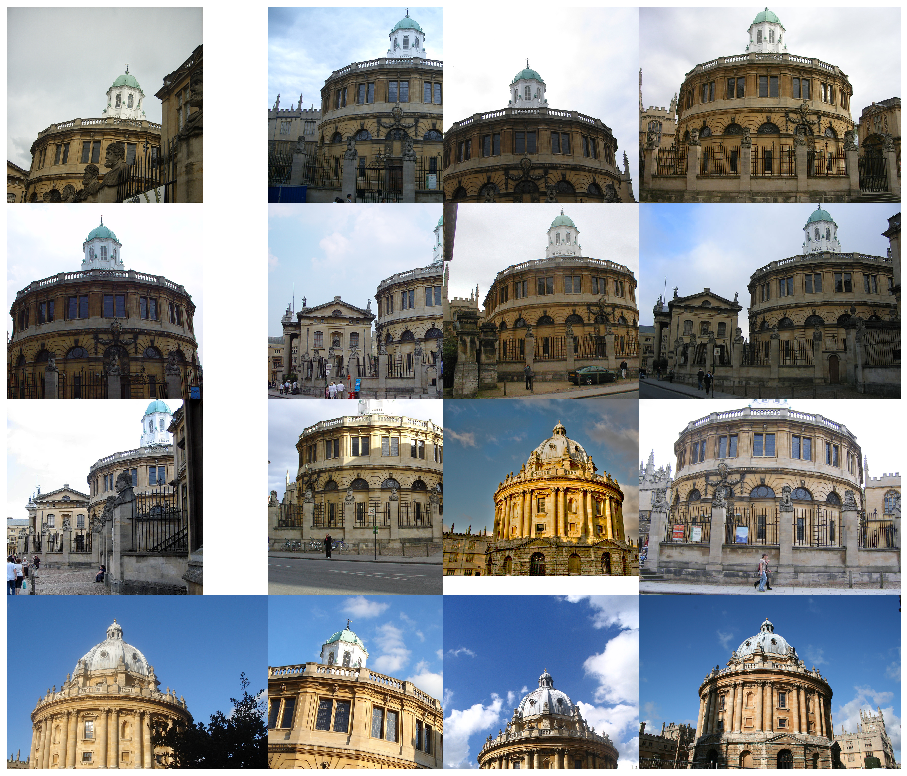

In [ ]:
import cv2
import matplotlib.pyplot as plt

query_fname = oxfordimages[3073]
img = cv2.cvtColor(cv2.imread(query_fname), cv2.COLOR_BGR2RGB)
top_k = IR.get_similar(img, 16)
visualize_grid([x.replace('../','') for x in top_k['paths']])
plt.show(block=True)

As we can see, results are quite good, but some of wrong images are in the front of the good correct. 
Let's try to fix it with the local features

In [ ]:
from local_feature_tutorial.wbs import *

In [ ]:
#export
from fastcore.foundation import patch
from fastprogress import progress_bar
@patch 
def spatially_verify(self:ImageRanker, img_fname, results_dict, two_view_matcher, vis=False):
    new_results = {}
    img1_fname = img_fname
    verif_results = []
    for i, img2_fname in enumerate(progress_bar(results_dict['paths'])):
        res = two_view_matcher.verify(img1_fname, img2_fname)
        verif_results.append(res)
        if vis:
            draw_matches_cv2(res['match_kpts1'], res['match_kpts2'],
                img1_fname, 
                img2_fname)
    num_inls = np.array([res['num_inl'] for res in verif_results])
    
    idxs = np.argsort(num_inls)[::-1]
    for k, v in results_dict.items():
        new_results[k] = [v[idx] for idx in idxs]
    new_results['num_inl'] =  [num_inls[idx] for idx in idxs]
    return  new_results

In [ ]:
wbs = TwoViewMatcher(detector = cv2.SIFT_create(4000, contrastThreshold=-10000,
                                              edgeThreshold=-10000),
                     descriptor = HardNetDesc(),
                     matcher=SNNMMatcher(0.9),
        geom_verif=degensac_Verifier())
topk_verif = IR.spatially_verify(query_fname, top_k, wbs, False)


In [ ]:
print (topk_verif['num_inl'])
visualize_grid(topk_verif['paths'])


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted Untitled.ipynb.
Converted datasets.ipynb.
Converted get_img_similarity.ipynb.
Converted index.ipynb.
Converted retrieval.ipynb.
Converted visualization.ipynb.
Converted wbs.ipynb.
